In [33]:
import torch, torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchsummary import summary
from torch.utils.data import TensorDataset, DataLoader

from tqdm import tqdm 
import numpy as np
from skimage.transform import resize
from numpy.fft import fftn, fftshift

import matplotlib.pyplot as plt
import matplotlib

import os

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

import os
os.environ["CUDA_VISIBLE_DEVICES"] = "4" 

In [34]:
torch.__version__

'1.10.0'

In [35]:
#!wget -L https://github.com/mcherukara/PtychoNN/blob/master/data/20191008_39_amp_pha_10nm_full.npy?raw=true 
#!wget -L https://github.com/mcherukara/PtychoNN/blob/master/data/20191008_39_diff.npz?raw=true


In [36]:
plt.style.use('seaborn-white')
#matplotlib.rc('xtick', labelsize=20) 
#matplotlib.rc('ytick', labelsize=20)
matplotlib.rc('font',family='Times New Roman')
matplotlib.rcParams['font.size'] = 20
plt.viridis()

<Figure size 432x288 with 0 Axes>

In [37]:
def plot3(data,titles):
    if(len(titles)<3):
        titles=["Plot1", "Plot2", "Plot3"]
    fig,ax = plt.subplots(1,3, figsize=(20,12))
    im=ax[0].imshow(data[0])
    ax[0].set_title(titles[0])
    ax[0].axis('off')
    plt.colorbar(im,ax=ax[0], fraction=0.046, pad=0.04)
    im=ax[1].imshow(data[1])
    ax[1].set_title(titles[1])
    ax[1].axis('off')
    plt.colorbar(im,ax=ax[1], fraction=0.046, pad=0.04)
    im=ax[2].imshow(data[2])
    ax[2].set_title(titles[2])
    ax[2].axis('off')
    plt.colorbar(im,ax=ax[2], fraction=0.046, pad=0.04)

In [38]:
torch.cuda.device_count()

1

In [39]:
H,W = 64,64
NLINES = 100 #How many lines of data to use for training?
NLTEST = 60 #How many lines for the test set?

N_VALID = 805 #How much to reserve for validation

**Note that the "path" can be different for different directory structures. For example, the original code in train.ipynb contains a different path.**  

In [40]:
path = os.getcwd()

MODEL_SAVE_PATH = path +'/trained_model/'
if (not os.path.isdir(MODEL_SAVE_PATH)):
    os.mkdir(MODEL_SAVE_PATH)

In [41]:
data_diffr = np.load('../../data/20191008_39_diff.npz')['arr_0']#np.load(path+'/../data/20191008_39_diff.npz')['arr_0']
real_space = np.load('../../data/20191008_39_amp_pha_10nm_full.npy')#np.load(path+'/../data/20191008_39_amp_pha_10nm_full.npy')

In [42]:
amp = np.abs(real_space)
ph = np.angle(real_space)
amp.shape

(161, 161, 64, 64)

In [43]:
try:
    data_diffr_red = np.load('../../data/20191008_39_diff_reduced.npz')['arr_0']
except:
    print(data_diffr.shape)
    #plt.matshow(np.log10(data_diffr[0,0]))

    data_diffr_red = np.zeros((data_diffr.shape[0],data_diffr.shape[1],64,64), dtype=float)
    for i in tqdm(range(data_diffr.shape[0])):
        for j in range(data_diffr.shape[1]):
            data_diffr_red[i,j] = resize(data_diffr[i,j,32:-32,32:-32],(64,64),preserve_range=True, anti_aliasing=True)
            data_diffr_red[i,j] = np.where(data_diffr_red[i,j]<3,0,data_diffr_red[i,j])
    np.savez_compressed('../../data/20191008_39_diff_reduced.npz', data_diffr_red)

In [44]:
data_diffr.shape, data_diffr_red.shape

((161, 161, 256, 256), (161, 161, 64, 64))

In [45]:
tst_strt = amp.shape[0]-NLTEST #Where to index from
print(tst_strt)

X_train = data_diffr_red[:NLINES,:].reshape(-1,H,W)[:,np.newaxis,:,:]
X_test = data_diffr_red[tst_strt:,tst_strt:].reshape(-1,H,W)[:,np.newaxis,:,:]
Y_I_train = amp[:NLINES,:].reshape(-1,H,W)[:,np.newaxis,:,:]
Y_I_test = amp[tst_strt:,tst_strt:].reshape(-1,H,W)[:,np.newaxis,:,:]
Y_phi_train = ph[:NLINES,:].reshape(-1,H,W)[:,np.newaxis,:,:]
Y_phi_test = ph[tst_strt:,tst_strt:].reshape(-1,H,W)[:,np.newaxis,:,:]

ntrain = X_train.shape[0]*X_train.shape[1]
ntest = X_test.shape[0]*X_test.shape[1]

print(X_train.shape, X_test.shape)

X_train, Y_I_train, Y_phi_train = shuffle(X_train, Y_I_train, Y_phi_train, random_state=0)

101
(16100, 1, 64, 64) (3600, 1, 64, 64)


In [46]:
#Training data
X_train_tensor = torch.Tensor(X_train) 
Y_I_train_tensor = torch.Tensor(Y_I_train) 
Y_phi_train_tensor = torch.Tensor(Y_phi_train)

#Test data
X_test_tensor = torch.Tensor(X_test) 
Y_I_test_tensor = torch.Tensor(Y_I_test) 
Y_phi_test_tensor = torch.Tensor(Y_phi_test)

print(Y_phi_train.max(), Y_phi_train.min())

print(X_train_tensor.shape, Y_I_train_tensor.shape, Y_phi_train_tensor.shape)

train_data = TensorDataset(X_train_tensor,Y_I_train_tensor,Y_phi_train_tensor)
test_data = TensorDataset(X_test_tensor)

3.1268637 -1.564053
torch.Size([16100, 1, 64, 64]) torch.Size([16100, 1, 64, 64]) torch.Size([16100, 1, 64, 64])


In [47]:
N_TRAIN = X_train_tensor.shape[0]
train_data2, valid_data = torch.utils.data.random_split(train_data,[N_TRAIN-N_VALID,N_VALID])
print(len(train_data2),len(valid_data),len(test_data))

15295 805 3600


In [48]:
BATCH_SIZE = 64
#download and load training data
trainloader = DataLoader(train_data2, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)

validloader = DataLoader(valid_data, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)

#same for test
#download and load training data
testloader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

In [49]:
from inception import InceptionBlock

In [50]:
c_red = {"3x3": 64, "5x5": 32}

class recon_model(nn.Module):

    def __init__(self):
        super(recon_model, self).__init__()


        self.encoder = nn.Sequential( 
            
            nn.Conv2d(in_channels=1, out_channels=64, kernel_size=3, stride=1, padding=(1,1)), #One conv to shape how Inception blocks need
            nn.BatchNorm2d(64),
            nn.ReLU(),
            
            InceptionBlock(64, c_red=c_red, c_out={"1x1": 16, "3x3": 32, "5x5": 8, "max": 8}, act_fn=nn.ReLU),
            InceptionBlock(64, c_red=c_red, c_out={"1x1": 24, "3x3": 48, "5x5": 12, "max": 12}, act_fn=nn.ReLU),
            nn.MaxPool2d((2,2)), #64x64->32x32
                           
            InceptionBlock(96, c_red=c_red, c_out={"1x1": 24, "3x3": 48, "5x5": 12, "max": 12}, act_fn=nn.ReLU),
            InceptionBlock(96, c_red=c_red, c_out={"1x1": 32, "3x3": 48, "5x5": 24, "max": 24}, act_fn=nn.ReLU),
            nn.MaxPool2d((2,2)), #32x32->16x16
                           
            InceptionBlock(128, c_red=c_red, c_out={"1x1": 32, "3x3": 48, "5x5": 24, "max": 24}, act_fn=nn.ReLU),
            InceptionBlock(128, c_red=c_red, c_out={"1x1": 48, "3x3": 72, "5x5": 36, "max": 36}, act_fn=nn.ReLU),
            nn.MaxPool2d((2,2)), #16x16->8x8            
            
            InceptionBlock(192, c_red=c_red, c_out={"1x1": 48, "3x3": 72, "5x5": 36, "max": 36}, act_fn=nn.ReLU),
            InceptionBlock(192, c_red=c_red, c_out={"1x1": 48, "3x3": 72, "5x5": 36, "max": 36}, act_fn=nn.ReLU),
            nn.MaxPool2d((2,2)), #8x8->4x4   
            #Last operation is concat, so c_conv must be = 1x1+3x3+5x5 size
          )

        self.decoder1 = nn.Sequential(

            InceptionBlock(192, c_red=c_red, c_out={"1x1": 48, "3x3": 72, "5x5": 36, "max": 36}, act_fn=nn.ReLU),
            InceptionBlock(192, c_red=c_red, c_out={"1x1": 32, "3x3": 48, "5x5": 24, "max": 24}, act_fn=nn.ReLU),
            nn.Upsample(scale_factor=2, mode='bilinear'),
            
            InceptionBlock(128, c_red=c_red, c_out={"1x1": 32, "3x3": 48, "5x5": 24, "max": 24}, act_fn=nn.ReLU),
            InceptionBlock(128, c_red=c_red, c_out={"1x1": 24, "3x3": 48, "5x5": 12, "max": 12}, act_fn=nn.ReLU),
            nn.Upsample(scale_factor=2, mode='bilinear'),

            InceptionBlock(96, c_red=c_red, c_out={"1x1": 24, "3x3": 48, "5x5": 12, "max": 12}, act_fn=nn.ReLU),
            InceptionBlock(96, c_red=c_red, c_out={"1x1": 16, "3x3": 32, "5x5": 8, "max": 8}, act_fn=nn.ReLU),
            nn.Upsample(scale_factor=2, mode='bilinear'),
            
            InceptionBlock(64, c_red=c_red, c_out={"1x1": 16, "3x3": 32, "5x5": 8, "max": 8}, act_fn=nn.ReLU),
            InceptionBlock(64, c_red=c_red, c_out={"1x1": 16, "3x3": 32, "5x5": 8, "max": 8}, act_fn=nn.ReLU),
            nn.Upsample(scale_factor=2, mode='bilinear'),

          nn.Conv2d(64, 1, 3, stride=1, padding=(1,1)),
          nn.Sigmoid() #Amplitude model
          )

        self.decoder2 = nn.Sequential(

            InceptionBlock(192, c_red=c_red, c_out={"1x1": 48, "3x3": 72, "5x5": 36, "max": 36}, act_fn=nn.ReLU),
            InceptionBlock(192, c_red=c_red, c_out={"1x1": 32, "3x3": 48, "5x5": 24, "max": 24}, act_fn=nn.ReLU),
            nn.Upsample(scale_factor=2, mode='bilinear'),
            
            InceptionBlock(128, c_red=c_red, c_out={"1x1": 32, "3x3": 48, "5x5": 24, "max": 24}, act_fn=nn.ReLU),
            InceptionBlock(128, c_red=c_red, c_out={"1x1": 24, "3x3": 48, "5x5": 12, "max": 12}, act_fn=nn.ReLU),
            nn.Upsample(scale_factor=2, mode='bilinear'),

            InceptionBlock(96, c_red=c_red, c_out={"1x1": 24, "3x3": 48, "5x5": 12, "max": 12}, act_fn=nn.ReLU),
            InceptionBlock(96, c_red=c_red, c_out={"1x1": 16, "3x3": 32, "5x5": 8, "max": 8}, act_fn=nn.ReLU),
            nn.Upsample(scale_factor=2, mode='bilinear'),
            
            InceptionBlock(64, c_red=c_red, c_out={"1x1": 16, "3x3": 32, "5x5": 8, "max": 8}, act_fn=nn.ReLU),
            InceptionBlock(64, c_red=c_red, c_out={"1x1": 16, "3x3": 32, "5x5": 8, "max": 8}, act_fn=nn.ReLU),
            nn.Upsample(scale_factor=2, mode='bilinear'),

          nn.Conv2d(64, 1, 3, stride=1, padding=(1,1)),
          nn.Tanh() #Phase model
          )
    
    def forward(self,x):
        with torch.cuda.amp.autocast():
            x1 = self.encoder(x)
            amp = self.decoder1(x1)
            ph = self.decoder2(x1)

            #Restore -pi to pi range
            ph = ph*np.pi #Using tanh activation (-1 to 1) for phase so multiply by pi

        return amp,ph

# Load best model and infer

In [51]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = recon_model()
model.to(device)
model.load_state_dict(torch.load(MODEL_SAVE_PATH+'best_model.pth'))
model.eval() #imp when have dropout etc
amps_eval = []
phs_eval = []
for i, ft_images in enumerate(testloader):
    ft_images = ft_images[0].to(device)
    amp_eval, ph_eval = model(ft_images)
    for j in range(ft_images.shape[0]):
        amps_eval.append(amp_eval[j].detach().to("cpu").numpy())
        phs_eval.append(ph_eval[j].detach().to("cpu").numpy())

/home/mcherukara/miniconda3/envs/PyTorch/lib/python3.9/site-packages/torch/nn/functional.py:3631: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(


In [52]:
amps_eval = np.array(amps_eval).squeeze()
phs_eval = np.array(phs_eval).squeeze()
print(amps_eval.shape, amps_eval.dtype)
print(phs_eval.shape, phs_eval.dtype)

(3600, 64, 64) float16
(3600, 64, 64) float16


<Figure size 432x288 with 0 Axes>

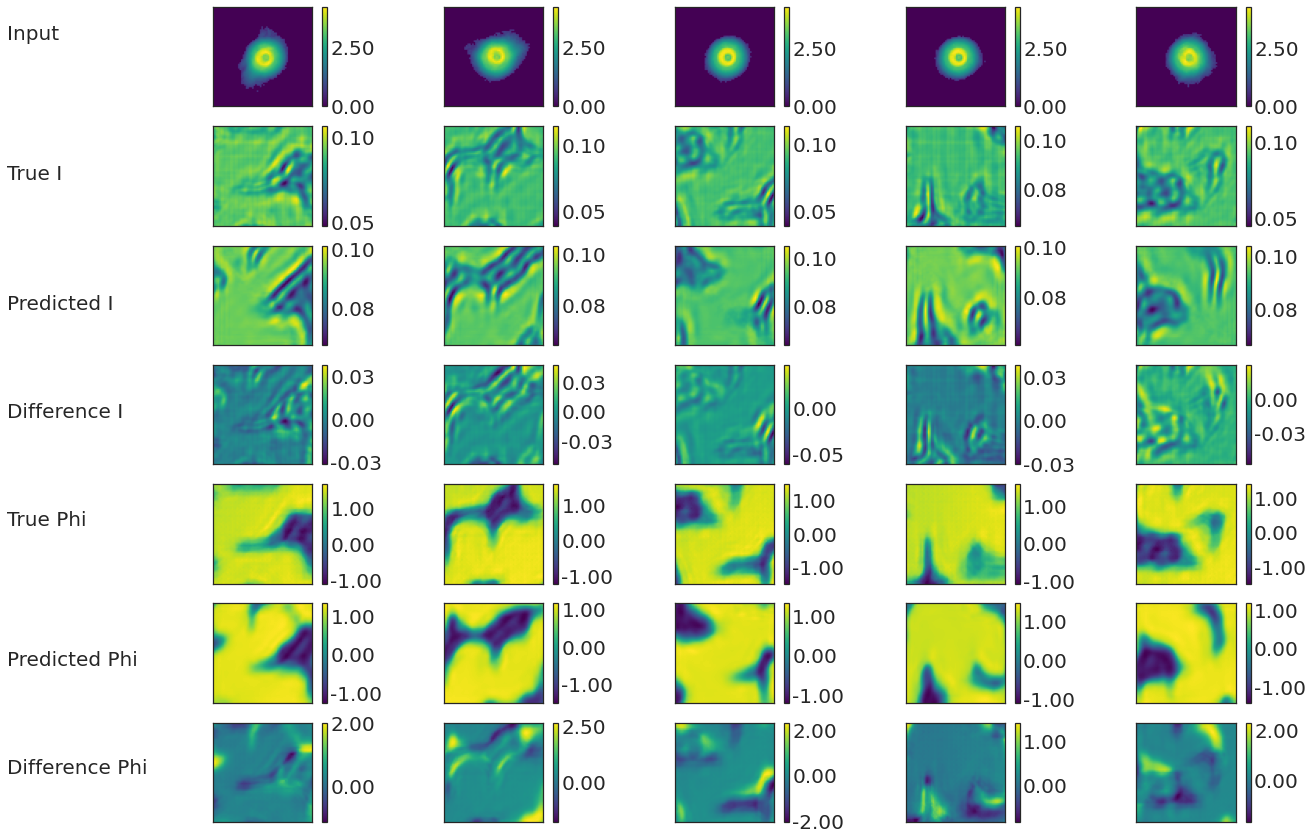

In [53]:
h,w = 64,64
ntest=amps_eval.shape[0]
plt.viridis()
n = 5
f,ax=plt.subplots(7,n,figsize=(20, 15))
plt.gcf().text(0.02, 0.85, "Input", fontsize=20)
plt.gcf().text(0.02, 0.72, "True I", fontsize=20)
plt.gcf().text(0.02, 0.6, "Predicted I", fontsize=20)
plt.gcf().text(0.02, 0.5, "Difference I", fontsize=20)
plt.gcf().text(0.02, 0.4, "True Phi", fontsize=20)
plt.gcf().text(0.02, 0.27, "Predicted Phi", fontsize=20)
plt.gcf().text(0.02, 0.17, "Difference Phi", fontsize=20)

for i in range(0,n):
    j=int(round(np.random.rand()*ntest))

        # display FT

    im=ax[0,i].imshow(np.log10(X_test[j].reshape(h, w)+1))
    plt.colorbar(im, ax=ax[0,i], format='%.2f')
    ax[0,i].get_xaxis().set_visible(False)
    ax[0,i].get_yaxis().set_visible(False)
    
    # display original intens
    im=ax[1,i].imshow(Y_I_test[j].reshape(h, w))
    plt.colorbar(im, ax=ax[1,i], format='%.2f')
    ax[1,i].get_xaxis().set_visible(False)
    ax[1,i].get_yaxis().set_visible(False)
    
    # display predicted intens
    im=ax[2,i].imshow(amps_eval[j].reshape(h, w).astype('float32'))
    plt.colorbar(im, ax=ax[2,i], format='%.2f')
    ax[2,i].get_xaxis().set_visible(False)
    ax[2,i].get_yaxis().set_visible(False)
    
        # display original phase
    im=ax[4,i].imshow(Y_phi_test[j].reshape(h, w))
    plt.colorbar(im, ax=ax[4,i], format='%.2f')
    ax[4,i].get_xaxis().set_visible(False)
    ax[4,i].get_yaxis().set_visible(False)
    
    # display predicted phase
    im=ax[5,i].imshow(phs_eval[j].reshape(h, w).astype('float32'))
    plt.colorbar(im, ax=ax[5,i], format='%.2f')
    ax[5,i].get_xaxis().set_visible(False)
    ax[5,i].get_yaxis().set_visible(False)
    
    
    #Difference in amplitude
    im=ax[3,i].imshow(Y_I_test[j].reshape(h, w) - amps_eval[j].reshape(h, w))
    plt.colorbar(im, ax=ax[3,i], format='%.2f')
    ax[3,i].get_xaxis().set_visible(False)
    ax[3,i].get_yaxis().set_visible(False)
    
    # Difference in phase
    im=ax[6,i].imshow(Y_phi_test[j].reshape(h, w) - phs_eval[j].reshape(h, w))
    plt.colorbar(im, ax=ax[6,i], format='%.2f')
    ax[6,i].get_xaxis().set_visible(False)
    ax[6,i].get_yaxis().set_visible(False)
    
plt.show()

In [54]:
point_size = 3
overlap = 4*point_size

In [55]:
tst_side = 60

composite_amp = np.zeros((tst_side*point_size+overlap,tst_side*point_size+overlap),float)
ctr = np.zeros_like(composite_amp)
data_reshaped = amps_eval.reshape(tst_side,tst_side,64,64)[:,:,32-int(overlap/2):32+int(overlap/2),
                                                     32-int(overlap/2):32+int(overlap/2)]

for i in range(tst_side):
    for j in range(tst_side):
        composite_amp[point_size*i:point_size*i+overlap, point_size*j:point_size*j+overlap] += data_reshaped[i,j]
        ctr[point_size*i:point_size*i+overlap, point_size*j:point_size*j+overlap] +=1

In [56]:

composite_phase = np.zeros((tst_side*point_size+overlap,tst_side*point_size+overlap),float)
ctr = np.zeros_like(composite_phase)
data_reshaped = phs_eval.reshape(tst_side,tst_side,64,64)[:,:,32-int(overlap/2):32+int(overlap/2),
                                                     32-int(overlap/2):32+int(overlap/2)]

for i in range(tst_side):
    for j in range(tst_side):
        composite_phase[point_size*i:point_size*i+overlap, point_size*j:point_size*j+overlap] += data_reshaped[i,j]
        ctr[point_size*i:point_size*i+overlap, point_size*j:point_size*j+overlap] +=1

In [57]:
stitched_phase = composite_phase[int(overlap/2):-int(overlap/2), int(overlap/2):-int(overlap/2)]/ctr[int(overlap/2)
                                                                    :-int(overlap/2), int(overlap/2):-int(overlap/2)]

stitched_amp = composite_amp[int(overlap/2):-int(overlap/2), int(overlap/2):-int(overlap/2)]/ctr[int(overlap/2)
                                                                    :-int(overlap/2), int(overlap/2):-int(overlap/2)]

stitched_amp_down = resize(stitched_amp, (60,60), preserve_range=True, anti_aliasing=True)
stitched_phase_down = resize(stitched_phase, (60,60), preserve_range=True, anti_aliasing=True)

In [58]:
true_amp = Y_I_test.reshape(NLTEST,NLTEST,64,64)
true_ph = Y_phi_test.reshape(NLTEST,NLTEST,64,64)

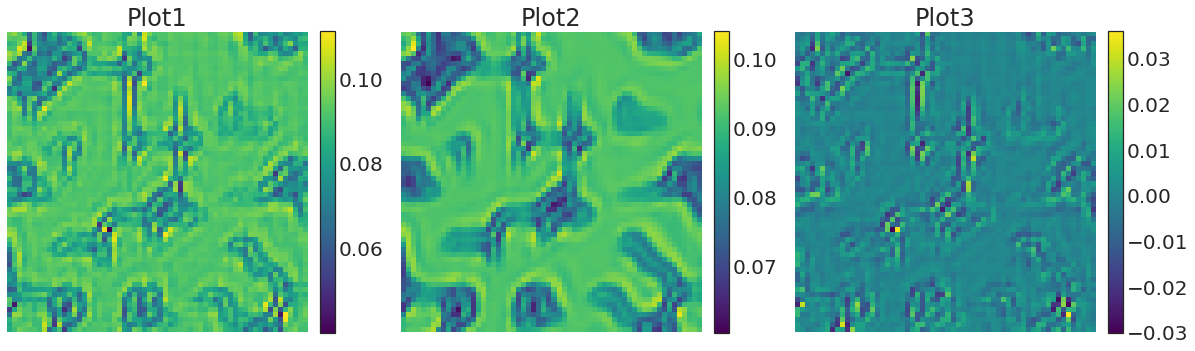

In [59]:
plot3([true_amp[:,:,32,32],stitched_amp_down,stitched_amp_down-true_amp[:,:,32,32]],[])

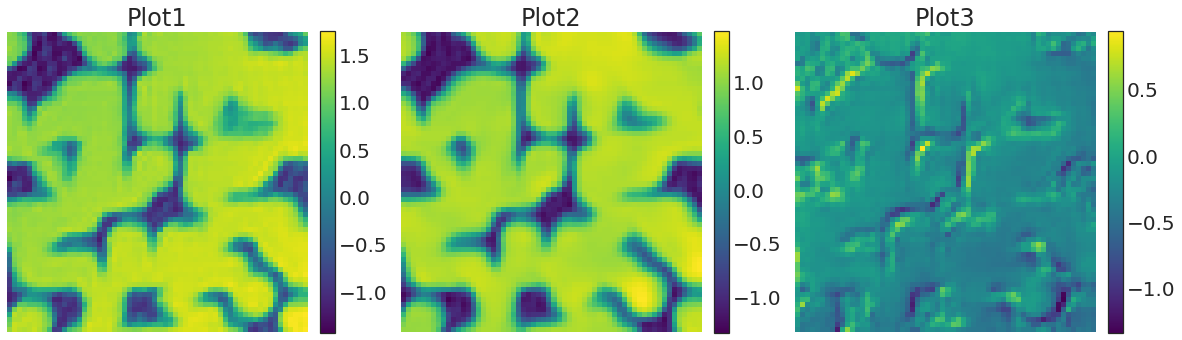

In [60]:
plot3([true_ph[:,:,32,32],stitched_phase_down,stitched_phase_down-true_ph[:,:,32,32]],[])

In [61]:
from sklearn.metrics import mean_squared_error as mse
from skimage.registration import phase_cross_correlation
print ("MSE in amplitude: ", mse(stitched_amp_down, true_amp[:,:,32,32]))
print ("MSE in phase: ", mse(stitched_phase_down, true_ph[:,:,32,32]))

MSE in amplitude:  3.8438827206540496e-05
MSE in phase:  0.09719899345723945


In [62]:
true_img = true_amp * np.exp(1j * true_ph)
stitched_img = stitched_amp_down * np.exp(1j * stitched_phase_down)

In [63]:
_roll, _err, _phase = phase_cross_correlation(true_img[:,:,32, 32], stitched_img)
phase_cross_correlation(true_img[:,:,32,32], stitched_img * np.exp(1j * _phase))

(array([0., 0.]), 0.2206116223738234, -2.2801927343353915e-17)